In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Layer, MaxPooling2D, Conv2D, Reshape
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import scipy.stats as st
from visualization_functions import *
import itertools
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import argparse
import os
import glob 

from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
from keras import activations

# visualize saliency
import matplotlib
import matplotlib.pyplot as plt

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Simulating Synthetic Images
The training images of two groups are simulated. Each image contains 4 Gaussian distribution density functions. Let the 4 standard deviations be

|  $\sigma_1$ | $\sigma_2$  |

|  $\sigma_3$ | $\sigma_4$  |

The 4 Gaussians are constructed such that

1. two diagonal Gaussians $\sigma_1,\sigma_4$ are linked to a factor of interest $mf$ (e.g. true effect between two classes)
2. two off-diagonal Gaussians $\sigma_2,\sigma_3$ are linked to two different confounding factors $cf_1, cf_2$.

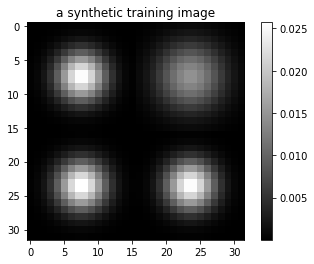

In [2]:
## Simulate Data
np.random.seed(0)

N = 512 # number of subjects in a group
labels = np.zeros((N*2,))
labels[N:] = 1

sig_base = 4
sig_offset = 2

# 2 confounding effects between 2 groups
cf1 = np.zeros((N*2,))
cf2 = np.zeros((N*2,))
cf1[:N] = np.random.normal(sig_base,1,size=N)
cf1[N:] = np.random.normal(sig_base+sig_offset,1,size=N)
cf2[:N] = np.random.normal(sig_base,1,size=N)
cf2[N:] = np.random.normal(sig_base+sig_offset,1,size=N)

# 2 major effects between 2 groups
mf = np.zeros((N*2,))
mf[:N] = np.random.normal(sig_base,0.5,size=N)
mf[N:] = np.random.normal(sig_base+sig_offset,0.5,size=N)

# simulate images
x = np.zeros((N*2,32,32,1))

for i in range(N*2):
    x[i,:16,:16,0] = gkern(kernlen=16, nsig=mf[i])
    x[i,16:,:16,0] = gkern(kernlen=16, nsig=cf1[i])
    x[i,:16,16:,0] = gkern(kernlen=16, nsig=cf2[i])
    x[i,16:,16:,0] = gkern(kernlen=16, nsig=mf[i])

plt.imshow(x[1,:,:,0],cmap='gray')
plt.colorbar()
plt.title("a synthetic training image");

# Training CNN
To differentiate the two classes, we train a simple 2D CNN. The model is comprised of an encoder and a predictor. 32 intermediate features are extracted, 8 from each block.

In [3]:
## contstruct and train a naive classifier
optimizer = Adam(0.0002)

# Build a naive feature encoder
input_feature_enc = Input(shape=(32,32,1), name='input_image')
feature_dense_enc = Conv2D(2, activation='tanh', kernel_size=(3,3),padding='valid')(input_feature_enc)
feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
feature_dense_enc = Conv2D(4, activation='tanh', kernel_size=(3,3),padding='valid')(feature_dense_enc)
feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
feature_dense_enc = Conv2D(8, activation='tanh', kernel_size=(3,3),padding='valid')(feature_dense_enc)
feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
feature_dense_enc = Flatten()(feature_dense_enc)
encoder = Model(input_feature_enc, feature_dense_enc)

# Build a naive classifier
input_feature_clf = Input(shape=(32,), name='input_feature_dense')
feature_clf = Dense(16, activation='tanh')(input_feature_clf)
prediction_score = Dense(1, name='prediction_score')(feature_clf)     
classifier = Model(input_feature_clf, prediction_score)

# integrate two native models
prediction_score_workflow = classifier(feature_dense_enc)
label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
workflow = Model(input_feature_enc, label_workflow)
workflow.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
workflow.summary()
workflow.fit(x,labels,
             epochs=50,
             batch_size=32,
             verbose=0)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 2)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 4)         76        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 4)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           296       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 8)           0         
__________

# Saliency Visualization
We first visualize the heat map using the vanilla keras-vis model. We can see both true effects and confounded effects are identified to be critical for classification.

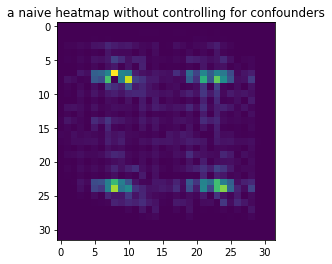

In [4]:
# visualize saliency

K_subject = 10 # visualize the average heatmap from first 10 subjects
saliency = np.zeros((32,32))
for subidx in itertools.chain(range(K_subject),range(N,N+K_subject)):
    layer_idx = utils.find_layer_idx(workflow, 'r_mean')

    # Swap softmax with linear
    workflow.layers[layer_idx].activation = activations.linear
    workflow_updated = utils.apply_modifications(workflow)

    grads = visualize_saliency(workflow_updated, layer_idx, filter_indices=0, seed_input=x[subidx])
    saliency = saliency + convert_jet_to_grey(grads/255.0,1)
    
plt.imshow(saliency/K_subject/2)
plt.title("a naive heatmap without controlling for confounders");

# Univariate Testing for Confounding Effects
Now we perform a GLM analysis for each of the 32 dense features $$y = c+\alpha*mf + \beta_1 * cf_1 + \beta_2 * cf_2$$

We claim that $y$ is confounded if $p$-value for either $\beta_1$ or $\beta_2$ is significant ($p<0.05$). From the results, we can see that only features extracted from the diagonal blocks are identified as confounded. Features from the off-diagonal blocks are either confounded by $cf_1$ or by $cf_2$. 

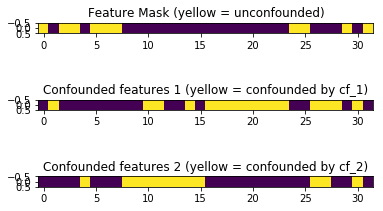

In [5]:
x_feature = encoder.predict(x)

from scipy import stats

p = np.zeros((32,4))
cr1 = np.zeros((32,))
cr2 = np.zeros((32,))

# GLM test for each feature
for i in range(32):
    X = np.zeros((N*2,4))
    X[:,0] = labels
    X[:,1] = cf1
    X[:,2] = cf2   
    X[:,3] = 1
    glm_model = sm.GLM(x_feature[:,i],X)
    glm_results = glm_model.fit()
    p[i,:] = glm_results.pvalues

mask = (p[:,1]>0.05) & (p[:,2]>0.05)
mask1 = (p[:,1]<0.05)
mask2 = (p[:,2]<0.05)

plt.subplot(3,1,1)
plt.imshow([mask])
plt.title("Feature Mask (yellow = unconfounded)")
plt.subplot(3,1,2)
plt.imshow([mask1])
plt.title("Confounded features 1 (yellow = confounded by cf_1)")
plt.subplot(3,1,3)
plt.imshow([mask2])
plt.title("Confounded features 2 (yellow = confounded by cf_2)");

# Model Refactorization
The influence from the subset of features with significant confounding effects can be removed from the heatmap by performing a partial back-propagation procedure, which uses the feature mask to block back-propagation in computing saliency scores. The procedure can be efficiently implemented with a simple model refactorization trick; that is, by adding a dummy layer $\mathcal{L}$ between the encoder and the predictor that performs $\mathcal{L}(\boldsymbol{x}) = \boldsymbol{x}\otimes \boldsymbol{b}_i \oplus ((1-\boldsymbol{b}_i) \otimes \boldsymbol{y}_i)$, where $\otimes$ and $\oplus$ denote element-wise operators, and $\boldsymbol{y}_i$ is a constant feature vector for image $i$ pre-computed by the trained ConvNet. The dummy layer essentially fixes the value of confounded features while keeping un-confounded features dependent on the input image. As such, the partial back-propagation can by simply computed by running the full back-propagation on the refactorized model.

In [6]:
# define a dummy layer
class BinaryMask(Layer):

    def __init__(self, output_dim, mask, pre_feature, **kwargs):
        self.output_dim = output_dim
        self.mask = mask
        self.pre_feature = pre_feature
        
        super(BinaryMask, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mask_tensor = K.variable(self.mask)
        self.pre_feature = K.variable(self.pre_feature)
        
        super(BinaryMask, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return x * self.mask_tensor + self.pre_feature

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# Confounder-free visualization
Rerunning saliency visualization on the refactorized models produces heap-maps for true effects.

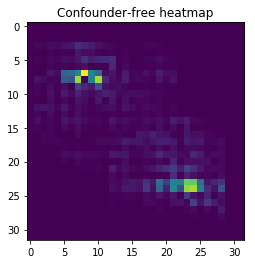

In [7]:
## Modify network by freezing certain entries
x_feature = encoder.predict(x)

K_subject = 10

saliency = np.zeros((32,32))
for subidx in itertools.chain(range(K_subject),range(N,N+K_subject)):
    pre_feature = x_feature[subidx] * (1-mask)

    feature_dense_enc_masked = BinaryMask(32,mask,pre_feature)(feature_dense_enc)
    prediction_score_workflow_updated = classifier(feature_dense_enc_masked)
    label_workflow_updated = Activation('linear', name='r_mean_updated')(prediction_score_workflow_updated)
    workflow_masked = Model(input_feature_enc, label_workflow_updated)
    
    layer_idx = utils.find_layer_idx(workflow_masked, 'r_mean_updated')
    
    grads = visualize_saliency(workflow_masked, layer_idx, filter_indices=0, seed_input=x[subidx])
    saliency = saliency + convert_jet_to_grey(grads/255.0,1)

plt.imshow(saliency/K_subject/2)
plt.title("Confounder-free heatmap");